# **Image classification**




#Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Input

#Download and explore the dataset

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import pathlib

data_dir = pathlib.Path("D:/Projectz/final-project/src/clone/image/Ir_NoBg/")

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

32577


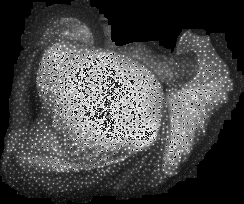

In [5]:
walk = list(data_dir.glob('walk/*'))
PIL.Image.open(str(walk[666]))

#Create a dataset

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 32577 files belonging to 5 classes.
Using 26062 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 32577 files belonging to 5 classes.
Using 6515 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['sit_foor', 'sitjar', 'sleep', 'squat', 'walk']


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.97584397


#Data augmentation

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_width,img_height,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

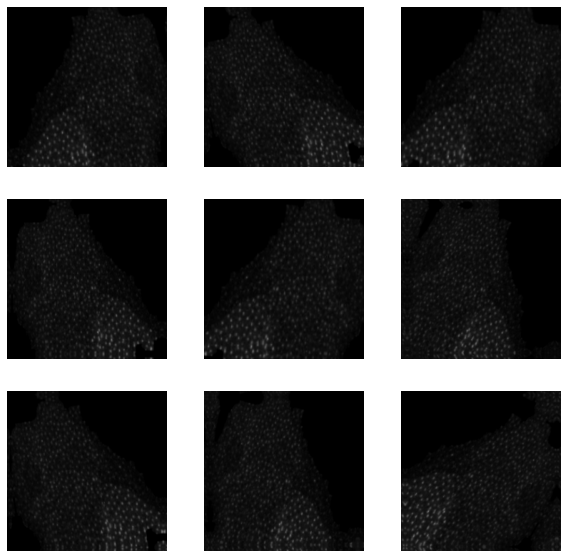

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    # print(augmented_images[0].numpy().dtype)
    # print(augmented_images[0].numpy().shape)

    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
# model = Sequential()
# model.add(data_augmentation)
model= keras.applications.ResNet50V2(
        weights=None,  # Load weights pre-trained on ImageNet.
        input_shape=(224, 224, 3),
        classes=len(class_names),
        classifier_activation="softmax",
        # input_tensor=None,
        include_top=True,)


# # model.trainable = False

# # Create new model on top
# inputs = keras.Input(shape=(224, 224, 3))
# # x = data_augmentation(inputs)  # Apply random data augmentation

# # # Pre-trained Xception weights requires that input be scaled
# # # from (0, 255) to a range of (-1., +1.), the rescaling layer
# # # outputs: `(inputs * scale) + offset`
# # # scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# # x = normalization_layer(x)

# # # The base model contains batchnorm layers. We want to keep them in inference mode
# # # when we unfreeze the base model for fine-tuning, so we make sure that the
# # # base_model is running in inference mode here.
# # x = model(x, training=False)
# # x = keras.layers.GlobalAveragePooling2D()(x)
# # x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)
model.summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history= model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10


D:\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


815/815 [==============================] - 423s 504ms/step - loss: 0.0906 - accuracy: 0.9771 - val_loss: 0.0065 - val_accuracy: 0.9979
Epoch 2/10
815/815 [==============================] - 459s 564ms/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.6018 - val_accuracy: 0.8876
Epoch 3/10
815/815 [==============================] - 460s 565ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 0.0091 - val_accuracy: 0.9972
Epoch 4/10
815/815 [==============================] - 466s 572ms/step - loss: 0.0163 - accuracy: 0.9947 - val_loss: 5.5387e-04 - val_accuracy: 0.9998
Epoch 5/10
815/815 [==============================] - 468s 575ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0176 - val_accuracy: 0.9940
Epoch 6/10
815/815 [==============================] - 485s 595ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0645 - val_accuracy: 0.9805
Epoch 7/10
815/815 [==============================] - 484s 595ms/step - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.0153 - val_ac

In [28]:
# model.save('/content/drive/MyDrive/activity/model/Depth_Bg.h5')
model.save("D:/Projectz/traindata/Ir_NoBG.pb")

INFO:tensorflow:Assets written to: D:/Projectz/traindata/Ir_NoBG.pb\assets


D:\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
D:\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#Visualize training results

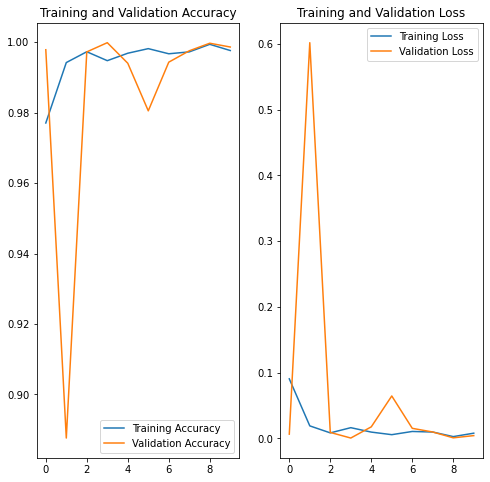

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()